In [1]:
!pip install mediapipe    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.0 MB 1.2 MB/s 
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 22.12.6 which is incompatible.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
FOLDER_DIR_DRIVE = '/content/drive/MyDrive/Badminton_sorted/Back_aug'

In [5]:
SAVE_DIR_DRIVE = '/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl'

In [8]:
#All Imports
from pathlib import Path   
import pandas as pd                                             
import re
import cv2
import os, sys, gc
import time
import numpy as np
import mediapipe as mp
from tqdm.auto import tqdm
import multiprocessing
from joblib import Parallel, delayed
from natsort import natsorted
from glob import glob
import math 
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Flatten
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [7]:
mp_holistic = mp.solutions.holistic               #Integrates pose, face and hand components
mp_drawing = mp.solutions.drawing_styles

N_FACE_LANDMARKS = 468
N_BODY_LANDMARKS = 33
N_HAND_LANDMARKS = 21

In [10]:
#function to generate pickle file for one video
def generate_keypoint(path,save_dir):
  class Counter(object):
      def __init__(self, initval=0):
          self.val = multiprocessing.RawValue("i", initval)
          self.lock = multiprocessing.Lock()

      def increment(self):
          with self.lock:
              self.val.value += 1

      @property
      def value(self):
          return self.val.value


  def process_body_landmarks(component, n_points):                                #5
      kps = np.zeros((n_points, 3))
      conf = np.zeros(n_points)
      if component is not None:
          landmarks = component.landmark
          kps = np.array([[p.x, p.y, p.z] for p in landmarks])
          conf = np.array([p.visibility for p in landmarks])
      return kps, conf


  def process_other_landmarks(component, n_points):                               #6 
      kps = np.zeros((n_points, 3)) 
      conf = np.zeros(n_points)
      if component is not None:
          landmarks = component.landmark
          kps = np.array([[p.x, p.y, p.z] for p in landmarks])
          conf = np.ones(n_points)
      return kps, conf


  def get_holistic_keypoints(                                                    #4
      frames, holistic=mp_holistic.Holistic(static_image_mode=False, model_complexity=2)    #False, treats the input images as a video stream.
  ):                                                                              

      keypoints = []
      confs = []

      for frame in frames:
          results = holistic.process(frame)

          body_data, body_conf = process_body_landmarks(                          #
              results.pose_landmarks, N_BODY_LANDMARKS
          )
          lh_data, lh_conf = process_other_landmarks(                             #
              results.left_hand_landmarks, N_HAND_LANDMARKS
          )
          rh_data, rh_conf = process_other_landmarks(                             #
              results.right_hand_landmarks, N_HAND_LANDMARKS
          )
          face_data, face_conf = process_other_landmarks(                         #
              results.face_landmarks, N_FACE_LANDMARKS
          )
          data = np.concatenate([body_data, face_data, lh_data, rh_data])
          conf = np.concatenate([body_conf, face_conf, lh_conf, rh_conf])

          keypoints.append(data)
          confs.append(conf)

      holistic.close()
      del holistic
      gc.collect()

      keypoints = np.stack(keypoints)
      confs = np.stack(confs)
      return keypoints, confs


  def gen_keypoints_for_frames(frames, save_path):                                #3 

      pose_kps, pose_confs = get_holistic_keypoints(frames)                       #Keypoints and Confidence level 
      body_kps = np.concatenate([pose_kps[:, :33, :], pose_kps[:, 501:, :]], axis=1)

      confs = np.concatenate([pose_confs[:, :33], pose_confs[:, 501:]], axis=1)

      d = {"keypoints": body_kps, "confidences": confs}

      with open(save_path + ".pkl", "wb") as f:
          pickle.dump(d, f, protocol=4)


  def load_frames_from_video(video_path):                                         #2
      frames = []
      vidcap = cv2.VideoCapture(video_path)
      while vidcap.isOpened():
          success, img = vidcap.read()
          if not success:
              break
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          # img = cv2.resize(img, (640, 480))
          frames.append(img)

      vidcap.release()
      # cv2.destroyAllWindows()
      return np.asarray(frames) 

  def gen_keypoints_for_video(video_path, save_path):                            #1 
      if not os.path.isfile(video_path):
          print("SKIPPING MISSING FILE:", video_path)
          return
      frames = load_frames_from_video(video_path)
      gen_keypoints_for_frames(frames, save_path)
  
  gen_keypoints_for_video(str(path),str(save_dir)) 


In [ ]:
#run this cell to generate pickle file for one video, first argument: video path, second argument: saving path
generate_keypoint("/content/drive/MyDrive/dataset/day 1/player 1/serve/back/Shot 2/color1662095488100.webm","output1")

In [ ]:
#run this cell to generate pickle files for the whoole folder

labels = os.listdir(FOLDER_DIR_DRIVE)              #where videos are                             
for label in labels:
  i = 0
  try:
      os.makedirs(os.path.join(SAVE_DIR_DRIVE,str(label)))         #where to save pickle files                   
  except:
      pass                                       
  paths = Path(os.path.join(FOLDER_DIR_DRIVE,str(label))).glob('**/*.webm')
  count = 0
  for path in paths:
    save_dir = os.path.join(SAVE_DIR_DRIVE,str(label),str(count))
    print(save_dir)
    try: 
      generate_keypoint(path,save_dir)
    except:
      print('error')
    print(path) 
    count += 1                                        

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662809886818_9.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1126
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662809886818_8.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1127
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662809886818_4.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1128
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662809886818_2.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1129
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662809886818_6.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1130
/content/drive/MyDrive/Badminton_sorted/Back_aug/smash/Copyofcolor1662812809256_1.webm
/content/drive/MyDrive/Badminton_sorted/Back_aug_pkl/smash/1131
/content/drive/MyDrive/Badminton_sorted/Bac

In [11]:
labels = os.listdir(SAVE_DIR_DRIVE) 
label_map = {key:value for value, key in enumerate(labels)}

In [ ]:
#run this cell to store the data in pickle file in arrays, and their corresponding label in sequence
sequences, targets = [], []
i = 0
for label in labels:
  paths = Path(SAVE_DIR_DRIVE + '/' + str(label)).glob('**/*.pkl')
  for path in paths:
      path_in_str = str(path)
      obj = pd.read_pickle(path_in_str)
      sequences.append(np.array(obj['keypoints']))
      targets.append(label_map[label])

padded_sequences = pad_sequences(sequences,maxlen=15, padding='post', dtype='float64') #to equilize the length of all sequences to 15
X = np.array(padded_sequences)
y = np.array(targets)
y = to_categorical(y)

In [12]:
# load the librarys and imports then run from here
X = np.load('/content/drive/MyDrive/Badminton_sorted/X_15_Data.npy')
y = np.load('/content/drive/MyDrive/Badminton_sorted/y_15_Data.npy')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle = True, random_state= 23) #stratified split

In [15]:
%load_ext tensorboard

In [16]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [17]:
kfold = KFold(n_splits=5, shuffle=True)

fold_no = 1

model = Sequential()
model.add(TimeDistributed(Flatten(input_shape=(75,3))))
model.add(LSTM(512, return_sequences=True, activation='tanh'))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

for train, test in kfold.split(X_train, y_train):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(X_train[train], y_train[train],epochs=12, callbacks=[tb_callback], shuffle = True)

  scores = model.evaluate(X_train[test], y_train[test], verbose=0)

  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')

  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/12
125/125 [==============================] - 16s 61ms/step - loss: 0.9288 - categorical_accuracy: 0.5394
Epoch 2/12
125/125 [==============================] - 10s 80ms/step - loss: 0.8096 - categorical_accuracy: 0.6031
Epoch 3/12
125/125 [==============================] - 8s 60ms/step - loss: 0.7736 - categorical_accuracy: 0.6213
Epoch 4/12
125/125 [==============================] - 8s 61ms/step - loss: 0.7270 - categorical_accuracy: 0.6349
Epoch 5/12
125/125 [==============================] - 8s 61ms/step - loss: 0.7379 - categorical_accuracy: 0.6273
Epoch 6/12
125/125 [==============================] - 8s 60ms/step - loss: 0.6769 - categorical_accuracy: 0.6558
Epoch 7/12
125/125 [==============================] - 8s 62ms/step - loss: 0.6476 - categorical_accuracy: 0.6605
Epoch 8/12
125/125 [==============================] - 8s 60ms/step - loss: 0.5921 - categorical_accuracy: 0.71

In [ ]:
#load pre trained model, directly from here
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/Badminton_sorted/final_model")

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 225)          0         
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 15, 512)           1511424   
                                                                 
 lstm_1 (LSTM)               (None, 15, 256)           787456    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                        

In [35]:
yhat = model.predict(X_test)

18/18 [==============================] - 0s 7ms/step


In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [22]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(ytrue, yhat)
print(cf_matrix)

[[182   4   6]
 [  7 177  31]
 [  5   5 135]]


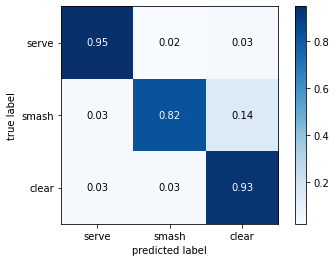

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
labs = ['serve', 'smash', 'clear']
fig, ax = plot_confusion_matrix(conf_mat=cf_matrix,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True)
ax.set_xticklabels([''] + labs)
ax.set_yticklabels([''] + labs)
plt.show()

In [24]:
accuracy_score(ytrue, yhat)

0.894927536231884

In [26]:
print(classification_report(yhat, ytrue))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       194
           1       0.82      0.95      0.88       186
           2       0.93      0.78      0.85       172

    accuracy                           0.89       552
   macro avg       0.90      0.89      0.89       552
weighted avg       0.90      0.89      0.89       552



In [ ]:
#from here on starts the code of real time video shots counting
testing_seqs = []
def generate_keypoint_locally(frames,save_dir):
  class Counter(object):
      # https://stackoverflow.com/a/47562583/
      def __init__(self, initval=0):
          self.val = multiprocessing.RawValue("i", initval)
          self.lock = multiprocessing.Lock()

      def increment(self):
          with self.lock:
              self.val.value += 1

      @property
      def value(self):
          return self.val.value


  def process_body_landmarks(component, n_points):                                #5
      kps = np.zeros((n_points, 3))
      conf = np.zeros(n_points)
      if component is not None:
          landmarks = component.landmark
          kps = np.array([[p.x, p.y, p.z] for p in landmarks])
          conf = np.array([p.visibility for p in landmarks])
      return kps, conf


  def process_other_landmarks(component, n_points):                               #6 
      kps = np.zeros((n_points, 3)) 
      conf = np.zeros(n_points)
      if component is not None:
          landmarks = component.landmark
          kps = np.array([[p.x, p.y, p.z] for p in landmarks])
          conf = np.ones(n_points)
      return kps, conf


  def get_holistic_keypoints(                                                    #4
      frames, holistic=mp_holistic.Holistic(static_image_mode=False, model_complexity=2)    #False, treats the input images as a video stream.
  ):                                                                              
      """
      For videos, it's optimal to create with `static_image_mode=False` for each video.
      https://google.github.io/mediapipe/solutions/holistic.html#static_image_mode
      """

      keypoints = []
      confs = []

      for frame in frames:
          # print(frame[0][0])
          results = holistic.process(frame)

          body_data, body_conf = process_body_landmarks(                          #
              results.pose_landmarks, N_BODY_LANDMARKS
          )
          lh_data, lh_conf = process_other_landmarks(                             #
              results.left_hand_landmarks, N_HAND_LANDMARKS
          )
          rh_data, rh_conf = process_other_landmarks(                             #
              results.right_hand_landmarks, N_HAND_LANDMARKS
          )
          face_data, face_conf = process_other_landmarks(                         #
              results.face_landmarks, N_FACE_LANDMARKS
          )
          data = np.concatenate([body_data, face_data, lh_data, rh_data])
          conf = np.concatenate([body_conf, face_conf, lh_conf, rh_conf])

          keypoints.append(data)
          confs.append(conf)

      holistic.close()
      del holistic
      gc.collect()

      keypoints = np.stack(keypoints)
      confs = np.stack(confs)
      return keypoints, confs


  def gen_keypoints_for_frames(frames, save_path):                                #3 

        # print(frames[0][0][0])
      pose_kps, pose_confs = get_holistic_keypoints(frames)                       #Keypoints and Confidence level 
      body_kps = np.concatenate([pose_kps[:, :33, :], pose_kps[:, 501:, :]], axis=1)

      confs = np.concatenate([pose_confs[:, :33], pose_confs[:, 501:]], axis=1)

      # d = {"keypoints": body_kps, "confidences": confs}
      testing_seqs.append(body_kps)
      # with open(save_path + ".pkl", "wb") as f:
      #     pickle.dump(d, f, protocol=4)


  def load_frames_from_video(video_path):                                         #2
      frames = []
      vidcap = cv2.VideoCapture(video_path)
      while vidcap.isOpened():
          success, img = vidcap.read()
          if not success:
              break
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          # img = cv2.resize(img, (640, 480))
          frames.append(img)

      vidcap.release()
      # cv2.destroyAllWindows()
      return np.asarray(frames)


  def gen_keypoints_for_video(video_path, save_path):                            #1 
      if not os.path.isfile(video_path):
          print("SKIPPING MISSING FILE:", video_path)
          return
      vidcap = cv2.VideoCapture(video_path)
      frames = []
      count = 0
      countframes = 0
      while vidcap.isOpened():
          success, img = vidcap.read()
          if not success:
              break
          if count % 2 == 0:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
              # img = cv2.resize(img, (640, 480))
              frames.append(img)
          count = count + 1
          countframes = countframes + 1
          if count %  30 == 0:
              gen_keypoints_for_frames(np.asarray(frames), save_path)
              # countframes = countframes - 21
              # vidcap.set(cv2.CAP_PROP_POS_FRAMES, countframes)
              print(countframes)
              frames = []
              # gc.collect()
          
              
      vidcap.release()
      # gen_keypoints_for_frames(frames, save_path)
  
  gen_keypoints_for_frames(np.asarray(frames),str(save_dir)) 


In [ ]:
#run this cell to generate an array of keypoints on a video and save it
video_path = "/content/drive/MyDrive/badminton video/outwomen.mp4"
if not os.path.isfile(video_path):
    print("SKIPPING MISSING FILE:", video_path)
vidcap = cv2.VideoCapture(video_path)
frames = []
count = 0
countframes = 0
while vidcap.isOpened():
    success, img = vidcap.read()
    if not success:
        break
    if count % 2 == 0:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.resize(img, (640, 480))
        frames.append(img)
    count = count + 1
    countframes = countframes + 1
    if count % 30 == 0:
        generate_keypoint_locally(frames, "")
        countframes = countframes - 21
        vidcap.set(cv2.CAP_PROP_POS_FRAMES, countframes)
        print(countframes)
        frames = []
        # gc.collect()
    
        
vidcap.release()
np.save("/content/drive/MyDrive/badminton video/outputwomen_seqs.npy", testing_seqs)

In [40]:
#run from here to load pre generated keypoints
new_test_1 = np.load("/content/drive/MyDrive/badminton video/output_seqs.npy")
new_test_2 = np.load("/content/drive/MyDrive/badminton video/outputpv_seqs.npy")
new_test_3 = np.load("/content/drive/MyDrive/badminton video/outputwomen_seqs.npy")

In [41]:
res_1 = model.predict(np.array(new_test_1))
res_2 = model.predict(np.array(new_test_2))
res_3 = model.predict(np.array(new_test_3))

162/162 [==============================] - 1s 7ms/step


In [45]:
res = [res_1, res_2, res_3]
num = 1
for results in res:
  counts = [0,0,0,0]
  for lb in results:
    if lb[np.argmax(lb)] > 0.8:
      counts[np.argmax(lb)] += 1
    else:
      counts[3] = counts[3] + 1
  dict_c = {"serve":counts[0], "smash":counts[1], "clear":counts[2], "others":counts[3]}
  print("Result ", num, ": ", dict_c)
  num += 1

Result  1 :  {'serve': 2390, 'smash': 33, 'clear': 362, 'others': 286}
Result  2 :  {'serve': 2818, 'smash': 10, 'clear': 261, 'others': 201}
Result  3 :  {'serve': 4207, 'smash': 12, 'clear': 640, 'others': 311}
